In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 28 20:42:11 2021

@author: Freedom
"""


# DREAM4 GNN 

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timeit
import matplotlib.pyplot as plt

In [106]:
'''GNN model'''
class GNN(nn.Module):
    def __init__(self, n=10, dim=5, layers=3, r=0.5, r2=0.5 ):
        super(GNN, self).__init__()
        
        self.dim=dim
        self.layer_gnn = layers
        self.n=n # number of nodes
        
        self.W_gnn = nn.ModuleList([nn.Linear(self.dim, self.dim)
                    for _ in range(self.layer_gnn)])
        
        # the learned adjacency matrix (n,n)
        self.A = torch.nn.Parameter(torch.ones((n,n)))
        #self.A = torch.nn.init.xavier_uniform(self.A)
        self.A.requires_grad = True
        
        self.gru = nn.GRU(input_size=self.n, hidden_size=self.n, num_layers=1, batch_first=True)
        
        # the weight (1x1 conv) converting between gene expression and features 
        self.W = torch.nn.Parameter(torch.ones((1,dim)))
        self.W = torch.nn.init.xavier_uniform(self.W)
        self.W.requires_grad = True
      
        # MSE loss with l1 regularization
        self.R = r
        self.R2 = r2
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        ''' 
            GNN forward. Model the evolving of gene regulatory networks.
            
                input: 
                    x: (batch_size, n_nodes, 1)  gene expression of time t
                output:
                    y: (batch_size, n_nodes, 1)  gene expression of time t+1
        '''
        x = x[None, :, :]
        _, x_emb = self.gru(x)
        x_emb = x_emb[0,0,:].reshape(-1,1)
        
        # convert x to hidden nodes xs (batch_size, n_nodes, dim) 
        xs = torch.matmul(x_emb, self.W)
        
        
        # gnn
        for i in range(self.layer_gnn):
            hs = torch.relu(self.W_gnn[i](xs))
            xs = xs + torch.matmul(self.A, hs)
        
        
        # convert xs to y, the expression value of next time point
        y = torch.matmul(xs,self.W.T)
        
        return y
    
    def predict(self,x,yt=None):
        '''
            predict one sample
            input: 
                x (batch_size, n_nodes, 1)  gene expression of time t
            output:
                y: (batch_size, n_nodes, 1)  gene expression of time t+1
                rmse: rmse of one sample (if y true is provided, None otherwise)
        '''
        
        y = self.forward(x)
        if yt!=None:
            mse = self.loss(y, yt)
            rmse = np.sqrt(mse.detach().cpu().numpy())
            return y,rmse
        else:
            return y
        
    def __call__(self, data, train=True):
        x, yt = data[0], data[1]
        yp = self.forward(x)
        
        abs_err = torch.abs(yt-yp)/yt
        abs_err = abs_err.sum()/self.n
        
        if train:
            # MSE loss with l1 regularization encouraging a sparse adj matrix
            loss = self.loss(yp, yt) + self.R*torch.norm(self.A, 1) #- self.R2*torch.norm(self.A, 2)
            mse = self.loss(yp, yt)
            return loss, mse
        else:
            return self.loss(yp, yt),abs_err

In [107]:
class Trainer(object):
    def __init__(self, model, weight_decay=0):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=1e-7, weight_decay=weight_decay) 

    def train(self, dataset):
        np.random.shuffle(dataset)
        N = len(dataset)
        loss_total = 0
        rmse=[]
        for data in dataset:
            loss,mse = self.model(data)
            rmse.append(mse.detach().cpu().numpy())
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.to('cpu').data.numpy()
            
        rmse=np.mean(rmse)
        rmse=np.sqrt(rmse)
        
        return loss_total/N,rmse

In [108]:
class Tester(object):
    def __init__(self, model):
        self.model = model

    def test(self, dataset):
        N = len(dataset)
        losses = []
        abs_err = []
        for data in dataset:
            loss,abr = self.model(data, train=False)
            losses.append(loss.detach().cpu().numpy())
            abs_err.append(abr.detach().cpu().numpy())
        total_mse=np.mean(losses)
        rmse=np.sqrt(total_mse)
        abs_err=np.mean(abs_err)
        return rmse,abs_err
    
    '''
    def save_AUCs(self, AUCs, filename):
        with open(filename, 'a') as f:
            f.write('\t'.join(map(str, AUCs)) + '\n')
    '''
    
    def save_model(self, model, filename):
        torch.save(model.state_dict(), filename)

In [109]:
'''load data'''
def load_data(network_size=10,path='..'):
    ''' 
        load DREAM4 time-series data with specified network size
        input:
            network_size: 10 or 100 genes
            path: the path to DREAM4 datasets folder
        output:
            networks: a list with data of 5 dictionaries 
            each includes data of:
            ['time_series_restoring', 'time_series_perturbing', 'wild_type', 'knock_outs']
                (5, 11, 10)             (5, 11, 10)              (6,10)        (10,10)
    '''
    
    networks=[]
    for i in range(5):
        
        # network is a dictionary containing all data of this network
        # keys: wild_type, time_series, knockouts
        network = {}
        
        
        wild_type = []
        time_series = []        
        kos = []
        
        
        # read time-series data
        folder = 'insilico_size'+str(network_size)+'_'+str(i+1)
        fname = folder+'/' +folder + '_timeseries.tsv'
        f = open(fname,'r')
        lines=f.readlines()
        f.close()
        
        data=[]
        count=0
        for l in lines[2:]:
            if l[0]!='\n' and count<20:
                
                d = np.array(l.strip().split())[1:]
                d=d.astype('float')
                data.append(d)
                    
                if (l.strip().split()[0]=='0.0'):
                    wild_type.append(d)
                    
                count+=1
            elif count==20:
                d = np.array(l.strip().split())[1:]
                d=d.astype('float')
                data.append(d)
                data=np.array(data)
                time_series.append(data)
                count=0
                data=[]
        
        time_series = np.array(time_series)
        
        network['time_series_restoring'] = time_series[:,10:,:]
        network['time_series_perturbing'] = time_series[:,:11,:]
        
        
        # read wildtype 
        
        fname = folder+'/' +folder + '_wildtype.tsv'
        f = open(fname,'r')
        lines=f.readlines()
        f.close()
        
        d = np.array(lines[1].strip().split())
        d=d.astype('float')
        
        wild_type.append(d)
        network['wild_type'] = np.array(wild_type) 
        
        # read knockouts
        fname = folder+'/' +folder + '_knockouts.tsv'
        f = open(fname,'r')
        lines=f.readlines()
        f.close()
        
        for l in lines[1:]:
            d = np.array(l.strip().split())
            d=d.astype('float')
            kos.append(d)
        kos=np.array(kos)
        
        network['knock_outs'] = kos 
        
        networks.append(network)
        
    return networks

In [110]:
def make_samples(dataset,device):
    '''
        make samples (x,y) using the data constructed using the load_data function
        inputs:
            dataset: the dictionary consisting data of:
                'time_series_restoring', 'time_series_perturbing', 'wild_type', 'knock_outs'
        output:
            mixed: mixed samples
            
    '''
    
    mixed = []
    time_series = []
    wild_type = []
    
    for matrix in dataset['time_series_restoring']:
        for i in range(len(matrix)-2):
            x1 = torch.FloatTensor(matrix[i].reshape(-1,1)).to(device)
            x2 = torch.FloatTensor(matrix[i+1].reshape(-1,1)).to(device)
            y = torch.FloatTensor(matrix[i+2].reshape(-1,1)).to(device)
            sample=(torch.cat([x1,x2], dim=1).T,y)
            mixed.append(sample)
            time_series.append(sample)
    
    wt = dataset['wild_type']
    for i in range(len(dataset['wild_type'])):
        for j in range(len(dataset['wild_type'])):
            x = torch.FloatTensor(wt[i].reshape(-1,1)).to(device)
            y = torch.FloatTensor(wt[j].reshape(-1,1)).to(device)
            sample=(x,y)
            mixed.append(sample)
            wild_type.append(sample)
            
    return mixed, time_series, wild_type

In [111]:
def split_mixed(mixed_data,ratio=0.8):
    '''
        split mixed dataset into train/test set
        input: 
            ratio: the ratio of training data
        output:
            train_data: training set
            test_data: test set
    '''
    
    n=len(mixed_data)
    n_train = int(ratio*n)
    train_data = mixed_data[:n_train]
    test_data = mixed_data[n_train:]
    
    return train_data,test_data

In [112]:
# get samples
mixed_data, time_series_data, wild_type_data, = make_samples(network_data,device)

# use mixed data and split into train/test set
train_data,test_data = split_mixed(time_series_data,0.8)

The code uses GPU...
Epoch	Time(sec)	Loss_train	RMSE_test	abs_err	
Training...


C:\Users\Dergel\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0	0.23473699999976816	24.978019555409748	0.47691768	2.1032221
1	0.4411326999997982	16.323993391460842	0.258085	1.1049111
2	0.6453805999999531	14.54122257232666	0.21644518	0.86270213
3	0.8554728999997678	12.439555327097574	0.18837	0.6727681
4	1.1157555999998294	10.050486617618137	0.18265502	0.49450165
5	1.3691717000001518	7.410004695256551	0.13170859	0.43734324
6	1.5648900000005597	4.512749625576867	0.10601119	0.2996081
7	1.7705603000003975	1.7961685061454773	0.2670686	0.74830514
8	1.9933240000000296	0.5112556575073136	0.4231448	1.3291278
9	2.2489574000001085	0.21905426225728458	0.37294134	1.1113646
10	2.465401600000405	0.12566363169915146	0.27965233	0.8007068
11	2.695942400000604	0.06568467699819142	0.19421177	0.54803896
12	2.9155909999999494	0.03700326978125506	0.14026874	0.36549118
13	3.1214256000002933	0.02582939522754815	0.11948536	0.2787386
14	3.420998000000509	0.023304244089457724	0.112027384	0.25645915
15	3.7855890999999247	0.02243404369801283	0.109988585	0.23858489
16	4.0645762

'trajectory prediction'

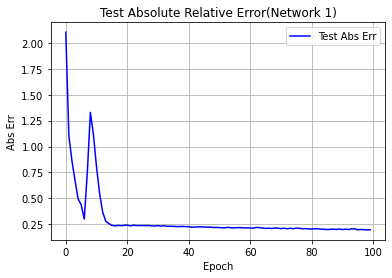

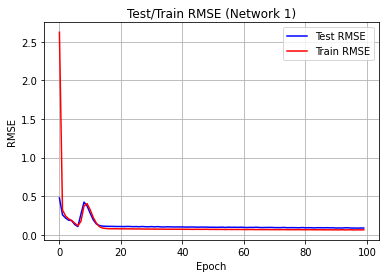

In [113]:
'''hyperparameters'''
network_number=0
n_nodes=10
dim=20
layers=3 
r = 0.2
r2 = 0 # encourage large A
epochs=100
lr=0.01
lr_decay=1
decay_interval=10



"""CPU or GPU."""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')




'''loading data'''
# data of 5 networks, each has 5 matrices of time-series data
networks = load_data(n_nodes,'..')

# choose one network as the dataset to work with 
network_data = networks[network_number]

# get samples
mixed_data, time_series_data, wild_type_data, = make_samples(network_data,device)

# use mixed data and split into train/test set
train_data,test_data = split_mixed(time_series_data,0.8)




"""Set a model."""
torch.manual_seed(1234)
model = GNN(n_nodes, dim, layers, r, r2).to(device)
trainer = Trainer(model)
tester = Tester(model)


"""Start training."""
log = ('Epoch\tTime(sec)\tLoss_train\tRMSE_test\tabs_err\t')
print(log)
print('Training...') 

start = timeit.default_timer()
trainer.optimizer.param_groups[0]['lr'] = lr
rmse_train_hist = []
rmse_test_hist = []
abr = []
for epoch in range( epochs):

    if epoch % decay_interval == 0:
        trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    loss_train,rmse_train = trainer.train(train_data)
    rmse_train_hist.append(rmse_train)

    rmse_test,abs_err = tester.test(test_data)
    rmse_test_hist.append(rmse_test)
    abr.append(abs_err)
    end = timeit.default_timer()
    time = end - start


    #tester.save_AUCs(AUCs, file_AUCs)
    #tester.save_model(model, file_model)

    print('\t'.join(map(str, [epoch, time, loss_train, rmse_test ,abs_err])))


'''plot loss'''
x_axis = np.arange(epochs)    
y_axis = abr

# abs err
fig, ax = plt.subplots()
ax.plot(x_axis, y_axis, color='blue',label='Test Abs Err')
#ax.plot(x_axis, loss1,color='red',label='Test Loss')
ax.set(xlabel='Epoch', ylabel='Abs Err',
   title='Test Absolute Relative Error(Network '+str(network_number+1)+')')
ax.legend()
ax.grid()



# RMSE    
y_axis2 = rmse_test_hist
y_axis3 = rmse_train_hist
fig2, ax2 = plt.subplots()
ax2.plot(x_axis, y_axis2, color='blue',label='Test RMSE')
ax2.plot(x_axis, y_axis3,color='red',label='Train RMSE')
ax2.set(xlabel='Epoch', ylabel='RMSE',
   title='Test/Train RMSE (Network '+str(network_number+1)+')')
ax2.legend()
ax2.grid()


'''example of testing'''
data = test_data[4]
print(data[1].T,'\n',model.predict(data[0],data[1])[0].T,
      '\n',
      model.predict(data[0],data[1])[1])





'''trajectory prediction'''
#TODO

